In [1]:
from tqdm.notebook import tqdm
import pandas
import numpy
import matplotlib.pyplot as plt


from ProblemInstance import ProblemInstance
from baseline_intra import bl_intra_1
from our_approach import leader_follower
from our_approach import leader_follower_est
from our_approach import leader_follower_oracle

In [2]:
def get_ops(problem, plan):
    return problem.operation_per_second(*problem.get_pc_packages_from_plan(*plan))

In [3]:
fontsize = 15
neurosim_dir = "NetStructure/"
summary_file = "NeuroSIMOut/summary.csv"
color_map = ["#ff8884", "indianred", "#f8ac8c",  "#2878b5", '#80b1d3', "#9ac9db"]

predef_N_X = numpy.array([
    12000, 400, 15600, 12000, 3600, 3600, 3600, 512, 90808, 
    15608, 15608, 15200, 1000, 1000, 1000, 1000, 1000, 1000,])

In [4]:
seed_set = numpy.arange(100)
operations = []

multi_model_problem = ProblemInstance(neurosim_dir)
multi_model_problem.read_nn_profile(summary_file)
multi_model_problem.set_buffer_size(100000000) # large buffer
N_M = multi_model_problem.N_M
nmrange = numpy.arange(2, N_M+1)

intra_ops = numpy.zeros_like(nmrange).astype(float)
bad_ops = numpy.zeros_like(nmrange).astype(float)
good_ops = numpy.zeros_like(nmrange).astype(float)
oracle_ops = numpy.zeros_like(nmrange).astype(float)

nn_ids = numpy.arange(N_M)
for seed in tqdm(seed_set):
    # print(f"random seed={seed}", "-"*100)
    numpy.random.seed(seed)
    numpy.random.shuffle(nn_ids)
    for i, n_m in enumerate(nmrange):
        nn = nn_ids[:n_m]
        multi_model_problem.get_exact_requests(nn_ids=nn, n_x=predef_N_X[nn])
        operations.append(multi_model_problem.operations)

        plan_intra = bl_intra_1(multi_model_problem) 
        intra_ops[i] += get_ops(multi_model_problem, plan_intra)

        plan_bad = leader_follower_est(multi_model_problem)
        bad_ops[i] += get_ops(multi_model_problem, plan_bad)
        
        plan_good = leader_follower(multi_model_problem)
        good_ops[i] += get_ops(multi_model_problem, plan_good)

        plan_oracle = leader_follower_oracle(multi_model_problem)
        oracle_ops[i] += get_ops(multi_model_problem, plan_oracle)
        
intra_ops /= len(seed_set)
bad_ops /= len(seed_set)
good_ops /= len(seed_set)
oracle_ops /= len(seed_set)

  0%|          | 0/100 [00:00<?, ?it/s]

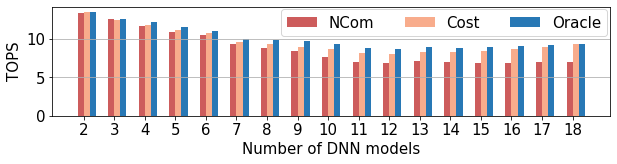

In [5]:
plt.figure(figsize=(10, 2))
names = nmrange
n_col = 4
width = 6
width_per_col = width/n_col
base_xticks = numpy.arange(len(names)) * (width+1.5)
plt.bar(base_xticks-width/2+width_per_col, bad_ops, width=width_per_col, label="NCom", color=color_map[1], align='center')
plt.bar(base_xticks-width/2+width_per_col*2, good_ops, width=width_per_col, label="Cost", color=color_map[2], align='center')
plt.bar(base_xticks-width/2+width_per_col*3, oracle_ops, width=width_per_col, label="Oracle", color=color_map[3], align='center')

plt.xticks(ticks=base_xticks-width_per_col/2, labels=names,rotation=0, fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.xlabel("Number of DNN models", fontsize=fontsize)
plt.ylabel("TOPS", fontsize=fontsize)
plt.legend(loc=(0.41, 0.73), ncol=6, fontsize=fontsize)
plt.grid(axis='y')

plt.show()